In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy as sp
import glob
import pickle as pckl

import matplotlib as mpl

import tensorflow as tf

%matplotlib inline
%precision 4
plt.style.use('ggplot')

# DD2447: Statistical Methods in Applied Computer Science 

## Assignemnt 2

We start by generating the data:

In [2]:
import SVDataGenerator

# T is the number of timesteps we want to generate
T = 10
# generation of the parameters phi,alpha,beta
parameters = SVDataGenerator.sv_parameter_generator(saveOpt=True, displayOpt=True, filename='myparameters.csv')
# generation of a sequence of 500 log-returns
yt = SVDataGenerator.sv_data_generator(parameters, T, displayOpt=True, saveOpt=True, filename='mydata.csv')

Generated parameters:
 phi =  0.980909887281
 sigma =  0.304909553587
 beta =  0.118417662892
Saved to  myparameters.csv
Data generated with parameters: (0.9809098872807408, 0.3049095535865708, 0.118417662891684)
Saved to  mydata.csv


In [3]:
yt = np.array(yt)
phi    = parameters[0]
sigma  = parameters[1]
beta   = parameters[2]

### Task 2.2 MCMC for the stohastic volatiliry model

We will now describe an MCMC sampler for the stohastic volatility model.

1. A time index t is fist sampled uniformly in $\{0, ... , T\}$.

2. Sample $x_t$ from the conditional distribution $p(x_t \mid \theta, x_{0:t-1}, x_{t+1:T},y_{1:T})$, which is given, up to a normalizing constant, by the likelihood function

$ p(x_{0:T}, y_{1:T} \mid \theta) = $

$ \mathcal{N}( x_0 \mid 0, \frac{\sigma^2}{1- \phi^2}) \sum_{t=1}^T [ \mathcal{N}(x_t \mid \phi x_{t-1},\sigma^2 ) \mathcal{N}(y_t \mid 0, \beta^2 exp(x_t))] 
$

In order to sample $x_t$, use a Metropolis-Hastings sampler characterized by one of the followin proposal samling densities $g_t(x_t' \mid x_t)$ each chosen with probability $1/3$:

1. If $t>0$, sample $ v_n \sim \mathcal{N}(v_n \mid 0,1)$ and set $ x_t' = \phi x_{t-1} + \sigma v_n $ . Otherwise, sample $ x_0' \sim \mathcal{N}(x_0' \mid 0, \frac{\sigma^2}{1- \phi^2})$ .
2. If $t<T$, sample $ v_n \sim \mathcal{N}(v_n \mid 0,1)$ and set $ x_t' = \frac{x_{t+1} - \sigma v_n}{\phi} $ . Otherwise, set $ x_T' = x_T$ .
3. If $t>0$, sample $ w_n \sim \mathcal{N}(w_n \mid 0,1)$ and set $ x_t' = 2 log(\frac{|y_t|}{\beta |w_n|}) $ . Otherwise, set $ x_0' = x_0$ .



#### Answers:

In this task we use Markov Chain Monte Carlo (MCMC) method to generate samples for the distribution $p(x_{0:T}, y_{1:T} \mid \theta)$. In general, the method starts by constucting a Markov chain whose stationary distribution is the target density of interest. 

MCMC method of choice is the Metropolis Hastings algorithm.
Apart from the distribution we want to sample, the algorithm requires another proposal distribution $g(\mathbf{x'} \mid \mathbf{x})$.


Having defined the proposal distribution we start by randomly initializing the initial state $\mathbf{x_0}$. Then we sample a new timestep $ t \sim U(0,T)$ which denotes the timestep of the stohastic volatility model we sample (not the Monte Carlo timestep). 

Next we sample a new $x' \sim g(x' \mid x)$ and compute the acceptance probability $ \alpha = \frac{ \widetilde{p}(x')g(x \mid x') }{  \widetilde{p}(x)g(x' \mid x) }$. If the ratio is higher than one the next state has a higher probability than the previous one and we will always take it, therefore the new acceptance probability is set to 1. Otherwise we want to encourage exploration around the state and we consider taking the next state with the probability $\alpha$.  

##### Initialisation

The initial state $\mathbf{x_0}$ needs to have a non-zero probability. If this condition isn't met there might be problems with computing the acceptance probability, if the denominator probability is zero acceptance probability is infinite, but that could be reported as a runtime error depending on the programming language and machine we use. The other possibility is that the proposed new state is still in the zero-probability area which would cause a case of $\frac{0}{0}$. Therefore we use Tensorflow framework for function optimisation using directed graphs with automatic operation differentitation. We build the computational graph for function:

$ p(x_{0:T}, y_{1:T} \mid \theta) = $

$ \mathcal{N}( x_0 \mid 0, \frac{\sigma^2}{1- \phi^2}) \sum_{t=1}^T [ \mathcal{N}(x_t \mid \phi x_{t-1},\sigma^2 ) \mathcal{N}(y_t \mid 0, \beta^2 exp(x_t))] 
$

Initialise a random initial state $x_{0:T}$ and use a stohastic gradient descent algorithm to find the **MAP** estimation for the given data $y_{1:T}$.

In [4]:
class MAPEstimate:
    
    def __init__(self,opt_steps, print_stats=False):
        self.g = tf.Graph()
        
        self.opt_steps=opt_steps
        self.print_stats = print_stats
        self.s=0
        
        self.feed_dict       = None
        self.run_operations  = None
        self.run_operations_ = None
        
    def display_state(self):
        if self.feed_dict is None or self.run_operations is None: 
            raise Exception('MAPEstimate :: Not implemented')
            
    def get_opt_state(self):
        if self.feed_dict is None or self.run_operations is None: 
            raise Exception('MAPEstimate :: Not implemented')
        return self.run_operations_
    
    def optimise_graph(self):
        if self.feed_dict is None or self.run_operations is None: 
            raise Exception('MAPEstimate :: Not implemented')
        
        with self.g.as_default():
            if self.print_stats:
                print('Starting training...')
            
            # initalise session
            self.sess = tf.Session()
            self.sess.as_default()
            self.sess.run(tf.global_variables_initializer())

            for s in range(self.opt_steps):
                self.run_operations_ = self.sess.run(self.run_operations,feed_dict=self.feed_dict)
                if self.print_stats:
                    self.display_state()

            if self.print_stats:
                print('Run saved... ')

            return True

In [5]:
class Assignment2_2_init_opt(MAPEstimate):
    
    def __init__(self,yt,sigma,phi,beta, opt_steps=1000, print_stats=False):
        # init super class
        MAPEstimate.__init__(self, opt_steps, print_stats)
            
        self.g = tf.Graph()
        self.T = len(yt)
        
        # Utility function for normal pdf
        def N(x,mu,sigma,scope):
            with tf.name_scope(scope):
                return 1. / tf.sqrt(2*np.pi*sigma**2) * tf.exp( -(x-mu)**2/(2*sigma**2) )

        # tensorflow grap construction    
        with self.g.as_default():
            # build graph
            with tf.name_scope('placeholders'):
                self.y_ = tf.placeholder(tf.float64,[self.T])
                self.sigma_ = tf.placeholder(tf.float64)
                self.phi_ = tf.placeholder(tf.float64)
                self.beta_ = tf.placeholder(tf.float64)
                if print_stats:
                    print('Setup placeholders...')

            with tf.variable_scope('variables'):
                self.x = tf.get_variable('x',
                                    dtype=tf.float64,
                                    shape=[self.T+1],
                                    trainable=True,
                                    initializer=tf.constant_initializer(np.zeros(self.T+1)))
                if print_stats:
                    print('Setup variables...')


            self.p = N(self.x[0], 0., self.sigma_**2/(1-self.phi_**2),'N0')

            # Define the total loss as the loss of every single component of this model
            for t in range(1,self.T+1):
                self.p *= N(self.x[t], self.phi_ * self.x[t-1],self.sigma_**2, 'Nx{}'.format(t))
                self.p *= N(self.y_[t-1],0., self.beta_**2 * tf.exp(self.x[t]), 'Ny{}'.format(t))
                if print_stats:
                    print('Chain: {}/{}'.format(t,self.T))
            if print_stats:
                print('Setup chain...')

            with tf.name_scope('loss'):
                self.loss = -tf.log(self.p)
                if print_stats:
                    print('Setup loss...')

            with tf.name_scope('train'):
                self.train_op = tf.train.AdamOptimizer().minimize(self.loss)
                if print_stats:
                    print('Generated training op...') 
        #        
        self.feed_dict={self.y_:yt, self.sigma_:sigma,self.phi_:phi,self.beta_:beta}
        self.run_operations = [self.train_op, self.loss,self.p]
        
        
    def display_state(self):
        print('{} | l: {} | p: {}'.format(self.s,self.run_operations_[1],self.run_operations_[2] ))
            
    def get_opt_state(self):
        return self.sess.run(self.x)
    

##### Modeling the proposal density

Since we are given three different proposal sampling densities, each having the same probability of being chosen, we can construct the following Mixture proposal. We can interpret this as marginalization of a discrete random variable $I$ over three possible classes, one for each function:

$$ g(x' \mid x) = \sum_{k=1}^3 g(x' \mid x, I=i) p(I=i) $$

where $p(I=i)=\frac{1}{3}$ for $ k \in \{ 1,2,3 \}$. 

We then write $ g(x' \mid x, I=i) $ as :

$$ g(x' \mid x, I=i) = g^1(x' \mid x)  \mathbf{1}_{i==1} + g^2(x' \mid x)  \mathbf{1}_{i==2} + g^3(x' \mid x)  \mathbf{1}_{i==3}  $$

where $\mathbf{1}_{L}$ is the indicator function witch results in $1$ if $L$ is true, and in $0$ otherwise. 

Each of $g^i(x' \mid x)$ is a probability density function for the next state $x'$. They are defined as functions of model parameters $\Theta = \{ \sigma, \phi, \beta \}$, predictions $y_{1:T}$, latent variables $x_{0:T}$ and random variables $v_n$ and $w_n$. Therefore, in order to sample from the proposal distribution it is necessary to use the change-of-variable rule for computing the right probability density function and cumulative distribution function needed for the inverse probability transform method of sampling. 

We start with the pdf $g^1(x' \mid x)$. If the selected timestep $ t \sim U(0,T)$ turns out to be $0$ we sample from the normal distribution $\mathcal{N}(x_0' \mid 0, \frac{\sigma^2}{1-\phi^2})$. Otherwise we obtain $x_t'$ as:

$$ x_t' = \phi x_{t-1} + \sigma v_n , \quad v_n \sim \mathcal{N}(v_n \mid 0,1) $$

The change-of-variable rule is defined as:

$$ f_Y(y) = \left | \frac{d}{dy} h^{-1}(y) \right | f_X(h^{-1}(y)) \quad \forall y \in g(X)$$

Inverse transformation is:

$$ v_n(x_t') = \frac{1}{\sigma} ( x_t' - \phi x_{t-1})$$

The derivative is :

$$ \frac{d}{d x_t'} v_n(x_t') = \frac{1}{\sigma} $$

And with:

$$  f_{V_n}( x ) = \sqrt{\frac{2}{\pi}} exp\{ -\frac{x^2}{2} \} $$

We obtain:

$$ f_{X_t'}(x_t') = \left | \frac{d}{dx_t'} v_n(x_t') \right | f_{V_n}(v_n(x_t')) $$

$$ f_{X_t'}(x_t') = \frac{1}{\sigma} \sqrt{\frac{2}{\pi}} exp\{ -\frac{(\frac{1}{\sigma} ( x_t' - \phi x_{t-1}))^2}{2} \} $$

$$ f_{X_t'}(x_t') = \frac{1}{\sqrt{2 \pi \sigma}} exp\{ -\frac{( x_t' - \phi x_{t-1})^2}{2 \sigma^2} \} $$

$$ f_{X_t'}(x_t') = \mathcal{N}(x_t' \mid \phi x_{t-1}, \sigma^2) $$

As we have proven, the transformed pdf is also a normal distribution with just a different set of parameters. Rewriting to original notation:

$$ g^1(x' \mid x) = \mathcal{N}(x_t' \mid \phi x_{t-1}, \sigma^2) $$

Putting it all together:

\begin{equation}
    g^1(x' \mid x)=
    \begin{cases}
      \mathcal{N}(x_0' \mid 0, \frac{\sigma^2}{1-\phi^2}), & \text{if}\ t=0 \\
      \mathcal{N}(x_t' \mid \phi x_{t-1}, \sigma^2) , & \text{otherwise}
    \end{cases}
  \end{equation}

$$ f_{X_t'}(x_t') =  \frac{1}{ \sqrt{2 \pi \frac{\sigma^2}{\phi^2} }} exp\{ -\frac{ (\frac{x_{t+1} - \phi x_t'}{\sigma})^2}{2} \}$$

$$ f_{X_t'}(x_t') =  \frac{1}{ \sqrt{2 \pi \frac{\sigma^2}{\phi^2} }} exp\{ -\frac{ ( x_t' - \frac{x_{t+1}}{\phi} )^2}{2 \frac{\phi^2}{\sigma^2}} \}$$

$$ f_{X_t'}(x_t') = \mathcal{N}(x_t' \mid \frac{x_{t+1}}{\phi}, \frac{\phi^2}{\sigma^2}) $$


$$ g^2(x' \mid x) = \mathcal{N}(x_t' \mid \frac{x_{t+1}}{\phi}, \frac{\phi^2}{\sigma^2}) $$



Then, the second case also consideres two different distribution with respect to $t \sim U(0,T)$. If the $t = T$ then we just copy the last value to the next: $x_T' = x_T$ .
Analogous to the first case, the second case will have: 

$$ x_t' =  \frac{( x_{t+1} + \sigma v_n)}{\phi}  , \quad v_n \sim \mathcal{N}(v_n \mid 0,1) $$

Inverse transformation is:

$$ v_n(x_t') = \frac{x_{t+1} - \phi x_t'}{\sigma}  $$

The derivative is :

$$ \frac{d}{d x_t'} v_n(x_t') = -\frac{\phi}{\sigma} $$

And with:

$$  f_{V_n}( x ) = \sqrt{\frac{2}{\pi}} exp\{ -\frac{x^2}{2} \} $$

We obtain:

$$ f_{X_t'}(x_t') = \left | \frac{d}{dx_t'} v_n(x_t') \right | f_{V_n}(v_n(x_t')) $$

$$ f_{X_t'}(x_t') = \left | -\frac{\phi}{\sigma} \right | \sqrt{\frac{2}{\pi}} exp\{ -\frac{ (\frac{x_{t+1} - \phi x_t'}{\sigma})^2}{2} \}$$

$$ f_{X_t'}(x_t') =  \frac{1}{ \sqrt{2 \pi \frac{\sigma^2}{\phi^2} }} exp\{ -\frac{ (\frac{x_{t+1} - \phi x_t'}{\sigma})^2}{2} \}$$

$$ f_{X_t'}(x_t') =  \frac{1}{ \sqrt{2 \pi \frac{\sigma^2}{\phi^2} }} exp\{ -\frac{ ( x_t' - \frac{x_{t+1}}{\phi} )^2}{2 \frac{\phi^2}{\sigma^2}} \}$$

$$ f_{X_t'}(x_t') = \mathcal{N}(x_t' \mid \frac{x_{t+1}}{\phi}, \frac{\phi^2}{\sigma^2}) $$


$$ g^2(x' \mid x) = \mathcal{N}(x_t' \mid \frac{x_{t+1}}{\phi}, \frac{\phi^2}{\sigma^2}) $$



\begin{equation}
    g^2(x' \mid x)=
    \begin{cases}
      \mathcal{N}(x_t' \mid \frac{x_{t+1}}{\phi}, \frac{\phi^2}{\sigma^2}), & \text{if}\ t<T \\
      x_T , & \text{otherwise}
    \end{cases}
  \end{equation}

Finally for the third function we have the fllowing rules. If the sampled $t \sim U(0,T)$ is equal to $0$ we set $x_0' = x_0$. Otherwise we have the following function:

$$ x_t' =  2 log(\frac{|y_t|}{\beta |w_n|})  , \quad w_n \sim \mathcal{N}(w_n \mid 0,1) $$

Inverse transformation is:

$$ w_n(x_t') = \left| \frac{|y_t|}{\beta} exp \{ - \frac{x_t'}{2}\} \right | $$

Which is positive on the whole domain so we can exclude the absolute function ( $y_t$ is already required to be absolute and $beta>0$ by definition).


The derivative is :

$$ \frac{d}{d x_t'} w_n(x_t') = -\frac{y_t}{2\beta} exp \{ - \frac{x_t'}{2}\} $$

And with:

$$  f_{|W_n|}( x ) = \frac{2}{\sqrt{2 \pi}}  exp\{ -\frac{x^2}{2} \} \quad \forall x \in [0,\inf)$$

Note that here our interval is restricted to only positive numbers, so therefore we need to correct for it in the pdf by multiplying the current value with $2$.

We obtain:

$$ f_{X_t'}(x_t') = \left | \frac{d}{dx_t'} w_n(x_t') \right | f_{W_n}(w_n(x_t')) $$

$$ f_{X_t'}(x_t') = \left | -\frac{y_t}{2\beta} exp \{ - \frac{x_t'}{2}\} \right | \frac{2}{\sqrt{2 \pi}}  exp\{ -\frac{(\frac{y_t}{\beta} exp \{ - \frac{x_t'}{2}\})^2}{2} \} $$

$$ f_{X_t'}(x_t') = \frac{|y_t|}{\beta \sqrt{2 \pi}} exp \bigg\{ -\frac{|y_t|^2}{2 \beta^2} exp\{-x_t' \} - \frac{x_t'}{2} \bigg\} $$


\begin{equation}
    g^3(x' \mid x)=
    \begin{cases}
      x_0, & \text{if}\ t=0 \\
      \frac{|y_t|}{\beta \sqrt{2 \pi}} exp \bigg\{ -\frac{|y_t|^2}{2 \beta^2} exp\{-x_t' \} - \frac{x_t'}{2} \bigg\}, & \text{otherwise}
    \end{cases}
  \end{equation}

All relevant equations, side by side :

$$ g(x' \mid x) = \sum_{k=1}^3 g(x' \mid x, I=i) p(I=i) $$

---

$$ g(x' \mid x, I=i) = g^1(x' \mid x)  \mathbf{1}_{i==1} + g^2(x' \mid x)  \mathbf{1}_{i==2} + g^3(x' \mid x)  \mathbf{1}_{i==3}  $$

---

\begin{equation}
    g^1(x' \mid x)=
    \begin{cases}
      \mathcal{N}(x_0' \mid 0, \frac{\sigma^2}{1-\phi^2}), & \text{if}\ t=0 \\
      \mathcal{N}(x_t' \mid \phi x_{t-1}, \sigma^2) , & \text{otherwise}
    \end{cases}
  \end{equation}

---

\begin{equation}
    g^2(x' \mid x)=
    \begin{cases}
      \mathcal{N}(x_t' \mid \frac{x_{t+1}}{\phi}, \frac{\phi^2}{\sigma^2}), & \text{if}\ t<T \\
      x_T , & \text{otherwise}
    \end{cases}
  \end{equation}

---

\begin{equation}
    g^3(x' \mid x)=
    \begin{cases}
      x_0, & \text{if}\ t=0 \\
      \frac{|y_t|}{\beta \sqrt{2 \pi}} exp \bigg\{ -\frac{|y_t|^2}{2 \beta^2} exp\{-x_t' \} - \frac{x_t'}{2} \bigg\}, & \text{otherwise}
    \end{cases}
  \end{equation}


##### Acceptance probability

Acceptance probability is given by the ratio:

$$ \alpha = \frac{ \widetilde{p}(x')g(x \mid x') }{  \widetilde{p}(x)g(x' \mid x) }$$

which can be simplified to :

$$ \alpha = \frac{ \widetilde{p}(x')}{  \widetilde{p}(x) }$$

if the proposial distribution is symmetrical. If it is not symetrical we need to maintain detailed balance (reversibility) of the stationary distribution by including the ratio between proposial distributon probabilies of the previous state and the next state. 

We know that there normal distributions are always symettric so we only check for the last equation.

By definition, a probability distribution is said to be symmetrix if and only if there exists a value $x_0$ such that 
$$ f(x_0 - \delta) = f(x_0 + \delta) \quad \forall \delta \in I\!R$$

From there with $\frac{|y_t|}{\sqrt{2 \pi \beta^2}} = C_1$ and $ \frac{|y_t|^2}{2 \beta^2} = C_2 $:

$$ C_1 * exp \bigg\{ -C_2 * exp\{-(x_0 - \delta) \} - \frac{x_0 - \delta}{2} \bigg\}  = C_1 * exp \bigg\{ -C_2 * exp\{-(x_0 + \delta) \} - \frac{x_0 + \delta}{2} \bigg\}$$

$$ -C_2 * exp\{-(x_0 - \delta) \} - \frac{x_0 - \delta}{2} = -C_2 * exp\{-(x_0 + \delta) \} - \frac{x_0 + \delta}{2} $$


$$ -C_2 * exp\{-(x_0 - \delta) \} + C_2 * exp\{-(x_0 + \delta) \} =  - \frac{x_0 + \delta}{2} + \frac{x_0 - \delta}{2}  $$

$$ C_2 *  e^{-x_0} ( e^{ \delta} - e^{ -\delta } ) = \delta $$


$$ e^{-x_0}  =  \frac{\delta}{C_2( e^{ \delta} - e^{ -\delta } )} $$
$$ x_0 =  - log(\frac{\delta}{C_2( e^{ \delta} - e^{ -\delta } )} ) $$
$$ x_0 =  log(\frac{C_2( e^{\delta } - e^{ \delta}   )}{ \delta} ) $$

$$ x_0 =  log\Big( \frac{|y_t|^2}{2 \beta^2} \frac{( e^{ \delta} - e^{ -\delta }   )}{ \delta} \Big) $$

The logarithmic function is defined only for non-negative number, therefore:

$$ \frac{( e^{ \delta} - e^{ -\delta }   )}{ \delta} > 0 $$ 

$$ ( e^{ \delta} - e^{ -\delta } > 0 \land \delta >0 ) \lor ( e^{ \delta} - e^{ -\delta } < 0 \land \delta <0 )$$


In the first case, if $\delta >0$ then $ e^\delta > e^{-\delta} $ is always true. Analogous is true for the second equation, if the $\delta <0$ then $ e^\delta < e^{-\delta} $ and therefore we can conclude that the given probability densityfunction is symmetric.

$$\frac{|y_t|}{\beta \sqrt{2 \pi}} exp \bigg\{ -\frac{|y_t|^2}{2 \beta^2} exp\{-x_t' \} - \frac{x_t'}{2} \bigg\}$$

The next graph displays a few plots for different $y_t$ values and a fixed $\beta=1$:

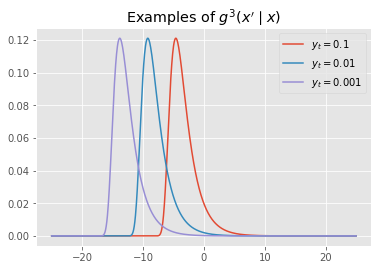

In [6]:
def f(x_t, y_t, beta):
    return np.abs(y_t) / (2*beta*np.sqrt( 2 * np.pi )) * np.exp( -y_t**2/(2*beta**2) * np.exp(-x) - x/2 )

x= np.linspace(-25,25,1000)
for y_t in[0.1,0.01,0.001]:
    plt.plot(x, f(x,y_t,1),label='$y_t = {}$'.format(y_t))
plt.title('Examples of $g^3(x\' \\mid x)$')
plt.legend();

This is why we will use the simplified acceptance probability ratio:

$$ \alpha = \frac{ \widetilde{p}(x')}{  \widetilde{p}(x) }$$

---

#### Algorithm

In [7]:
class ProbabilityFunction:
    
    def __init__(self,x0):
        self.x=x0

    def rvs(self):
        pass
    
    def pdf(self,x):
        pass
    
    def cdf(self,x):
        pass
    
    def update_state(self,x):
        self.x=x

In [8]:
class TimeDepProbabilityFunction:
    
    def __init__(self,x0):
        self.x=x0
    
    def rvs(self,t):
        pass
    
    def pdf(self,t,x_t):
        pass
    
    def cdf(self,t,x_t):
        pass
    
    def update_state(self,x):
        self.x=x

$$ g(x' \mid x) = \sum_{k=1}^3 g(x' \mid x, I=i) p(I=i) $$

---

$$ g(x' \mid x, I=i) = g^1(x' \mid x)  \mathbf{1}_{i==1} + g^2(x' \mid x)  \mathbf{1}_{i==2} + g^3(x' \mid x)  \mathbf{1}_{i==3}  $$

---

In [9]:
class MultipleUniformProposals(TimeDepProbabilityFunction):
    
    def __init__(self,f_list):
        self.f_list=f_list
        self.n = len(self.f_list)
        
    def rvs(self,t):
        u = st.uniform.rvs()
        
        # interval associated to this probability
        I_low=0
        I_high=1./self.n
        for i in range(self.n-1):
            if I_low <u and u<=I_high:
                return self.f_list[i].rvs(t)
            I_low = I_high
            I_high += 1./self.n
        return self.f_list[self.n-1].rvs(t)

    
    def pdf(self,t,x_t):
        pdf = 0
        for i in range(self.n):
            pdf += self.f_list[i].pdf(t,x_t)
        return pdf
    
    def cdf(self,t,x_t):
        cdf = 0
        for i in range(self.n):
            cdf += self.f_list[i].cdf(t,x_t)
        return cdf

    def update_params(self,param_name,value):
        if param_name is 'sigma':
            for f in self.f_list:
                f.sigma = value
        elif param_name is 'beta':
            for f in self.f_list:
                f.beta = value
    
    def update_state(self,x):
        for f in self.f_list:
            f.update_state(x)

---

\begin{equation}
    g^1(x' \mid x)=
    \begin{cases}
      \mathcal{N}(x_0' \mid 0, \frac{\sigma^2}{1-\phi^2}), & \text{if}\ t=0 \\
      \mathcal{N}(x_t' \mid \phi x_{t-1}, \sigma^2) , & \text{otherwise}
    \end{cases}
  \end{equation}



In [10]:
class Proposal_1(TimeDepProbabilityFunction):

    def __init__(self,x0,phi,sigma):
        TimeDepProbabilityFunction.__init__(self, x0)
        self.phi   = phi
        self.sigma = sigma
    
    def rvs(self,t):
        if t is 0:
            return st.norm.rvs(loc=0, scale=self.sigma**2/(1-self.phi**2))
        else:
            return st.norm.rvs(loc=self.phi * self.x[t-1], scale=self.sigma**2)
        
    
    def pdf(self,t,x_t):
        if t is 0:
            return st.norm.pdf(x_t,loc=0, scale=self.sigma**2/(1-self.phi**2))
        else:
            return st.norm.pdf(x_t,loc=self.phi * self.x[t-1], scale=self.sigma**2)

    
    def cdf(self,t,x_t):
        if t is 0:
            return st.norm.cdf(x_t,loc=0, scale=self.sigma**2/(1-self.phi**2))
        else:
            return st.norm.cdf(x_t,loc=self.phi * self.x[t-1], scale=self.sigma**2)


---
\begin{equation}
    g^2(x' \mid x)=
    \begin{cases}
      \mathcal{N}(x_t' \mid \frac{x_{t+1}}{\phi}, \frac{\phi^2}{\sigma^2}), & \text{if}\ t<T \\
      x_T , & \text{otherwise}
    \end{cases}
  \end{equation}


In [11]:
class Proposal_2(TimeDepProbabilityFunction):

    def __init__(self,x0,phi,sigma,T,eps=1e-16):
        TimeDepProbabilityFunction.__init__(self, x0)
        self.phi   = phi
        self.sigma = sigma
        self.T = T
        self.eps=eps
    
    def rvs(self,t):
        if t < T-1:
            return st.norm.rvs(loc=self.x[t+1]/(self.phi**2), scale=self.phi**2/(self.phi**2))
        else:
            return self.x[T-1]
        
    
    def pdf(self,t,x_t):
        if t < T-1:
            return st.norm.pdf(x_t,loc=self.x[t+1]/(self.phi**2), scale=self.phi**2/(self.phi**2))
        else:
            res = np.abs(x_t-self.x[T-1]) < self.eps
            return res.astype(float)
            #return 1. if np.abs(x_t-self.x[T-1]) < self.eps else 0.

    
    def cdf(self,t,x_t):
        if t < T-1:
            return st.norm.cdf(x_t,loc=x[t+1]/(self.phi**2), scale=self.phi**2/(self.phi**2))
        else:
            return (x_t >= self.x[T-1]).astype(float)
            #return 0. if x_t < self.x[T-1] else 1.


---

\begin{equation}
    g^3(x' \mid x)=
    \begin{cases}
      x_0, & \text{if}\ t=0 \\
      \frac{|y_t|}{\beta \sqrt{2 \pi}} exp \bigg\{ -\frac{|y_t|^2}{2 \beta^2} exp\{-x_t' \} - \frac{x_t'}{2} \bigg\}, & \text{otherwise}
    \end{cases}
  \end{equation}

In [12]:
class Proposal_3(TimeDepProbabilityFunction):

    def __init__(self,x0,beta,y,eps=1e-6, x_start=0, d_x=10):
        TimeDepProbabilityFunction.__init__(self, x0)
        self.beta = beta
        self.y=y
        self.eps = eps
        self.x_start=0
        self.d_x=d_x
        
    def rvs(self,t):
        if t is 0:
            return self.x[t]
        else:
            # hyperparameter for defining the envelope distribution
            norm_sigma = 10
            x_star = np.log(self.y[t]**2/(self.beta**2)) # maximum of the given function
            f_star = self._f(t,x_star)
            M = f_star/( 1/np.sqrt(2*np.pi*norm_sigma**2)) # scale max of the gaussian to be over the max of given function
            # M is the constant in inequality: Mq(x) >= p(x) 
            
            while True:
                u = st.uniform.rvs()
                
                x_sample = st.norm.rvs(loc=x_star,scale=norm_sigma)
                y_t = self._f(t,x_sample) # y of target
                y_g = M*st.norm.pdf(x_sample,loc=x_star,scale=norm_sigma) # y of gaussian 
                
                if u <= y_t / y_g:
                    return x_sample
        
    def pdf(self,t,x_t):
        if t is 0:
            res = np.abs(x_t-self.x[0]) < self.eps
            return res.astype(float)
            
            return 1. if abs(x_t-self.x[0]) < self.eps else 0.
        else:
            return self._f(t,x_t)

    def cdf(self,t,x_t):
        if t is 0:
            #return 0. if x_t < self.x[0] else 1.
            return (x_t >= self.x[0]).astype(float)
        else:
            return sp.integrate.quad(lambda x: self._f(t,x),np.NINF, x_t)[0] # the return is the probabiliy and error
            
    def _f(self,t,x_t):
        C = 2* np.abs(self.y[t])/(self.beta * np.sqrt(2*np.pi))
        power_1 = - self.y[t]**2/(2*self.beta**2) * np.exp(-x_t)
        power_2 = -x_t/2

        return C * np.exp(power_1 + power_2)


Experimenting with different envelopes for rejection sampling:

In [13]:
# def _f(t,x_t,beta  =1):
#     C = np.abs(yt[t])/(beta * np.sqrt(2*np.pi))
#     power_1 = - (yt[t])**2/(2*beta**2) * np.exp(-x_t)
#     power_2 = -x_t/2

#     return C * np.exp(power_1 + power_2)


# for t in range(T): #range(T):    
#     norm_sigma = 10
#     beta_test = 1
#     x_star = np.log(yt[t]**2/(beta_test**2)) # maximum of the given function
#     f_star = _f(t,x_star)
#     norm_star = ( 1/np.sqrt(2*np.pi*norm_sigma**2))
    
#     M = f_star/norm_star # scale max of the gaussian to be over the max of given function
    
#     # plot data
#     x = np.linspace(x_star-norm_sigma*3,x_star+norm_sigma*3,1000)                
#     y_t = _f(t,x) # y of target
#     y_g = M*st.norm.pdf(x,loc=x_star,scale=norm_sigma) # y of gaussian 
    
    
#     print('Max_norm_val : ', norm_star)
#     print('Max_f_val : ', f_star)
#     print('Ratio : ',M)
    
#     print ( 'Number of points in which our function isnt satisfied = {}'.format(sum( y_g<y_t)) )
#     plt.plot(x,y_t,'g')
#     plt.axvline(x=x_star)
#     plt.plot(x,y_g,'b')
    
#     print('max @ {}'.format(x_star))
#     print('val_max @ {}'.format(f_star))
    
#     plt.show()

In [14]:
class LikelihoodFunction(ProbabilityFunction):
    
    def __init__(self,phi,sigma,beta,yt):
        self.phi=phi
        self.sigma=sigma
        self.beta=beta
        self.yt = yt
        
    def rvs(self):
        raise Exception('LikelihoodFunction :: rvs not implemented')
        
    
    def pdf(self,x):
        p = st.norm.pdf(x[0], loc=0, scale= self.sigma**2/(1-self.phi**2))
        
        for t in range(1,len(x)) :
            p*=st.norm.pdf(x[t], loc= self.phi * x[t-1], scale= self.sigma**2)
            p*=st.norm.pdf(yt[t-1], loc=0, scale= self.beta**2*np.exp(x[t]))
        return p
    
    def cdf(self,x):
        raise Exception('LikelihoodFunction :: cdf not implemented')
        
    def update_phi(self,phi_n):
        self.phi = phi_n
        
    def update_sigma(self,sigma_n):
        self.sigma = sigma_n
        
    def update_beta(self,beta_n):
        self.beta = beta_n
        
    

In [15]:
opt_2_2 = Assignment2_2_init_opt(yt,sigma,phi,beta,print_stats=True)
opt_2_2.optimise_graph()
x0 = opt_2_2.get_opt_state()

Setup placeholders...
Setup variables...
Chain: 1/10
Chain: 2/10
Chain: 3/10
Chain: 4/10
Chain: 5/10
Chain: 6/10
Chain: 7/10
Chain: 8/10
Chain: 9/10
Chain: 10/10
Setup chain...
Setup loss...
Generated training op...
Starting training...
0 | l: inf | p: 0.0
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 |

0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan


0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan
0 | l: nan | p: nan


In [16]:
# define the proposal distribution
g1 = Proposal_1(x0=x0,phi=phi,sigma=sigma)
g2 = Proposal_2(x0=x0,phi=phi,sigma=sigma,T=T)
g3 = Proposal_3(x0=x0,beta=beta,y=yt)
g = MultipleUniformProposals(f_list=[g1,g2,g3])

In [17]:
p = LikelihoodFunction(phi=phi,sigma=sigma,beta=beta,yt=yt)

In [18]:
class MetropolisHastingsSampler:
    
    def __init__(self,x0,g,p,T,N_bi):
        self.x=x0
        self.g=g
        self.p=p
        self.T=T
        self.sample(N_bi)
        
    def sample(self,N):
        x_current = self.x
        #prepare a samples list
        samples = []

        # for burn_in + N samples repeat
        for s in range(N):
            # sample from g
            t = int(st.uniform.rvs() * self.T)
            x_t = g.rvs(t)

            x_next = np.copy(x_current)
            x_next[t] = x_t

            p_c = p.pdf(x_current)
            p_n = p.pdf(x_next)
            alpha = p_n/p_c
            r=min(1,alpha)

            # include sample
            u = st.uniform.rvs()
            if u < r:
                x_current = x_next
                g.update_state(x_current)
            samples.append(x_current )
                
        # update the last state to the new state
        self.x = x_current
        return samples

In [19]:
mh_sampler1 = MetropolisHastingsSampler(x0,g,p,T,N_bi=1000)

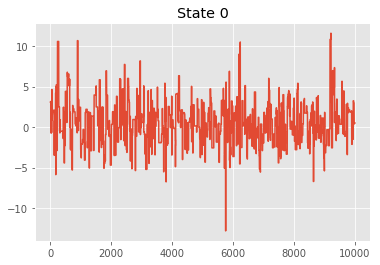

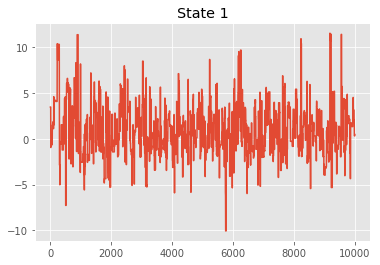

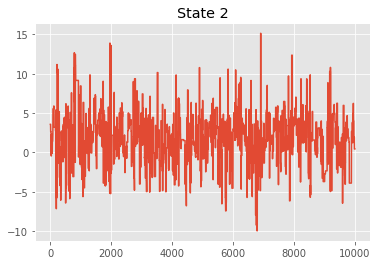

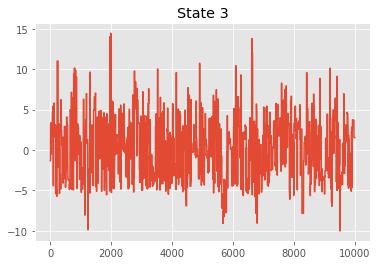

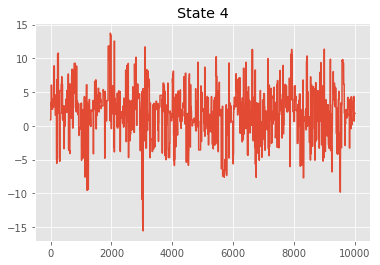

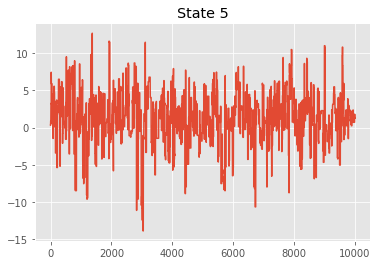

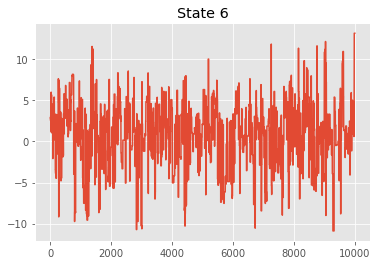

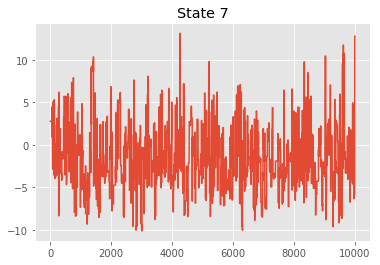

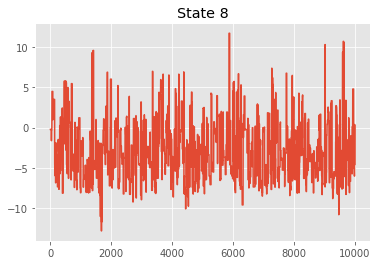

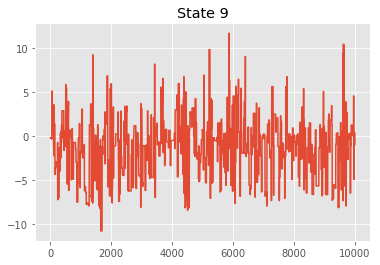

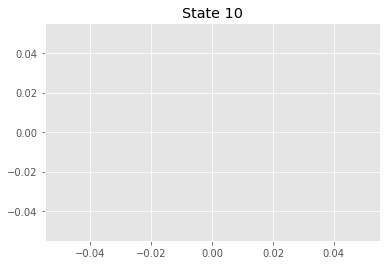

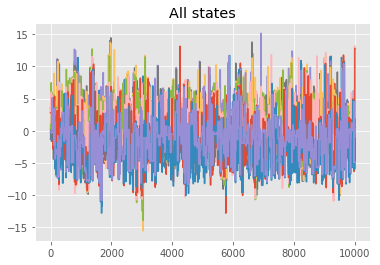

In [20]:
mh_samples_=mh_sampler1.sample(N=10000)
mh_data = np.array(mh_samples_)
x_dims = len(x0)
# separate
for i in range(x_dims):
    plt.plot(mh_data[:,i])
    plt.title('State {}'.format(i))
    plt.savefig('figures/T_2_2/Q1/plt_x{}.png'.format(i))
    plt.show()
    
# together 
for i in range(x_dims):
    plt.plot(mh_data[:,i])
plt.title('All states');
plt.savefig('figures/T_2_2/Q1/plt_x_all.png')
        

**Question 4:** Derive the Metropolis-Hastings algorithm and implement MCMC sampler. 

**Question 5:** Report the marginal distribution of $\sigma^2$ and $\beta^2$ on histograms. 

For this task the state is extended by two more variables $\sigma^2$ and $\beta^2$ beside the so far used $x_{0:T}$ states. Initially they will be sampled from the Inverse Gamma distribution like follows:

$$ \sigma^2 \sim \mathcal{IG}(a = 0.01, b = 0.01)$$
$$ \beta^2 \sim \mathcal{IG}(a = 0.01, b = 0.01)$$


We will reuse the scheme of sampling uniformly a different variable at each time step but now including the mentioned paramters. The proposed distributions are as follows :

$$ p(\sigma^2 \mid \phi, x_{0:T}, y_{1:T} ) = \mathcal{IG} \left( \sigma^2 \mid a+\frac{T}{2}, b + \frac{1}{2} \sum_{t=1}^T (x_t - \phi x_{t-1})^2 \right) $$

$$ p(\beta^2 \mid \phi, x_{0:T}, y_{1:T} ) = \mathcal{IG} \left( \beta^2 \mid a+\frac{T}{2}, b + \frac{1}{2} \sum_{t=1}^T exp(-x_t)y_t^2 \right) $$

The algorithm is now changed so that in each iteration we sample a value sigma, then a value beta and then a uniformly chosen variable $x_{0:T}$. 

In [21]:
class ProposalSigma(ProbabilityFunction):

    def __init__(self,x0,a,b):
        ProbabilityFunction.__init__(self, x0)
        self.T= len(x0)-1
        self.a=a
        self.b=b
        #cache this data
        self.sum_diff_x = sum( [ (self.x[t] - self.x[t-1])**2  for t in range(1,self.T+1) ] )
        
    def rvs(self):
        param_a = self.a + self.T/2
        param_b = self.b + 1./2 * self.sum_diff_x        
        return st.invgamma.rvs(a=param_a,scale=param_b)
    
    def pdf(self,x):
        param_a = self.a + self.T/2
        param_b = self.b + 1./2 * self.sum_diff_x
        
        return st.invgamma.pdf(x,a=param_a,scale=param_b)
    
    def cdf(self,x):
        param_a = self.a + self.T/2
        param_b = self.b + 1./2 * self.sum_diff_x
        
        return st.invgamma.cdf(x,a=param_a,scale=param_b)
    
    def update_state(self,x):
        self.x=x
        self.sum_diff_x = sum( [ (self.x[t] - self.x[t-1])**2  for t in range(1,self.T+1) ] )

In [22]:
class ProposalBeta(ProbabilityFunction):

    def __init__(self,x0,y,a,b):
        ProbabilityFunction.__init__(self, x0)
        self.T= len(y)
        self.y=y
        self.a=a
        self.b=b
        #cache this data
        self.sum_exp_xy = sum( [ np.exp(-self.x[t])*y[t]**2 for t in range(self.T)] )
    
    
    def rvs(self):
        param_a = self.a + self.T/2
        param_b = self.b + 1./2 * self.sum_exp_xy        
        return st.invgamma.rvs(a=param_a,scale=param_b)
    
    def pdf(self,x):
        param_a = self.a + self.T/2
        param_b = self.b + 1./2 * self.sum_exp_xy
        return st.invgamma.pdf(x,a=param_a,scale=param_b)
    
    def cdf(self,x):
        param_a = self.a + self.T/2
        param_b = self.b + 1./2 * self.sum_exp_xy
        return st.invgamma.cdf(x,a=param_a,scale=param_b)
    
    def update_state(self,x):
        self.x=x
        self.sum_exp_xy = sum( [ np.exp(-self.x[t])*y[t]**2 for t in range(self.T)] )


#### The experiment

In [30]:
import SVDataGenerator

# T is the number of timesteps we want to generate
T = 10
# generation of the parameters phi,alpha,beta
parameters = SVDataGenerator.sv_parameter_generator(saveOpt=True, displayOpt=True, filename='myparameters.csv')
# generation of a sequence of 500 log-returns
yt = SVDataGenerator.sv_data_generator(parameters, T, displayOpt=True, saveOpt=True, filename='mydata.csv') 

yt = np.array(yt)
phi    = parameters[0]
sigma  = parameters[1]
beta   = parameters[2]

Generated parameters:
 phi =  0.962440352244
 sigma =  0.125725026503
 beta =  0.185386611366
Saved to  myparameters.csv
Data generated with parameters: (0.96244035224408753, 0.12572502650349127, 0.18538661136571408)
Saved to  mydata.csv


In [31]:
# Sample initial sigma^2 and beta^2 variables

a = 0.01
b = 0.01

sigma0 = st.invgamma.rvs(a=a,scale=b)
beta0 = st.invgamma.rvs(a=a,scale=b)

# Initialise the x_{0:T} given the sampled beta and sigma
opt_2_2 = Assignment2_2_init_opt(yt,sigma,phi,beta,print_stats=True)
opt_2_2.optimise_graph()
x0 = opt_2_2.get_opt_state()


Setup placeholders...
Setup variables...
Chain: 1/10
Chain: 2/10
Chain: 3/10
Chain: 4/10
Chain: 5/10
Chain: 6/10
Chain: 7/10
Chain: 8/10
Chain: 9/10
Chain: 10/10
Setup chain...
Setup loss...
Generated training op...
Starting training...
0 | l: 81.9856627852 | p: 2.47787307857e-36
0 | l: 81.7191539134 | p: 3.23461346144e-36
0 | l: 81.4527453149 | p: 4.22203835047e-36
0 | l: 81.1867241172 | p: 5.50875822708e-36
0 | l: 80.9212077774 | p: 7.18399453592e-36
0 | l: 80.656256781 | p: 9.36338215682e-36
0 | l: 80.3919087327 | p: 1.21965681759e-35
0 | l: 80.1281893013 | p: 1.58770400963e-35
0 | l: 79.8651195089 | p: 2.06547194656e-35
0 | l: 79.6027163449 | p: 2.68521798223e-35
0 | l: 79.3409931383 | p: 3.48854630009e-35
0 | l: 79.0799619276 | p: 4.52906867219e-35
0 | l: 78.8196329924 | p: 5.87581787099e-35
0 | l: 78.5600146352 | p: 7.61761721658e-35
0 | l: 78.3011148099 | p: 9.86865373985e-35
0 | l: 78.0429401608 | p: 1.27756126763e-34
0 | l: 77.7854973491 | p: 1.65267603358e-34
0 | l: 77.528792

0 | l: 41.4953284439 | p: 9.52374661104e-19
0 | l: 41.3515448423 | p: 1.09964437446e-18
0 | l: 41.2081756841 | p: 1.26916092072e-18
0 | l: 41.0652195091 | p: 1.46420460716e-18
0 | l: 40.9226748663 | p: 1.68852743279e-18
0 | l: 40.7805403261 | p: 1.94641914361e-18
0 | l: 40.6388144838 | p: 2.24278229274e-18
0 | l: 40.4974961135 | p: 2.58321710069e-18
0 | l: 40.3565838541 | p: 2.97411887834e-18
0 | l: 40.2160772461 | p: 3.4227845913e-18
0 | l: 40.0759745384 | p: 3.93754382999e-18
0 | l: 39.9362784028 | p: 4.52787742943e-18
0 | l: 39.7969814268 | p: 5.20463849948e-18
0 | l: 39.658094047 | p: 5.98010201302e-18
0 | l: 39.5195860315 | p: 6.86849931737e-18
0 | l: 39.3814777099 | p: 7.88572343148e-18
0 | l: 39.2437540157 | p: 9.05011674976e-18
0 | l: 39.1064350193 | p: 1.03822400056e-17
0 | l: 38.9695193495 | p: 1.1905641036e-17
0 | l: 38.8329937208 | p: 1.36472488668e-17
0 | l: 38.696852871 | p: 1.56376083227e-17
0 | l: 38.5610894958 | p: 1.79114859112e-17
0 | l: 38.4257177069 | p: 2.05079777

0 | l: 17.5386120988 | p: 2.41589216447e-08
0 | l: 17.4600166353 | p: 2.61343149981e-08
0 | l: 17.3816223509 | p: 2.82655425792e-08
0 | l: 17.303428636 | p: 3.05644387553e-08
0 | l: 17.2254348562 | p: 3.30437017481e-08
0 | l: 17.1476403935 | p: 3.57169527656e-08
0 | l: 17.0700446703 | p: 3.85987991797e-08
0 | l: 16.9926471291 | p: 4.17049033359e-08
0 | l: 16.9154472002 | p: 4.50520567023e-08
0 | l: 16.8384442983 | p: 4.8658258065e-08
0 | l: 16.7616378246 | p: 5.25427966763e-08
0 | l: 16.6850271867 | p: 5.67263398389e-08
0 | l: 16.6086118086 | p: 6.12310263958e-08
0 | l: 16.5323911304 | p: 6.60805667905e-08
0 | l: 16.4563645935 | p: 7.13003505139e-08
0 | l: 16.3805316261 | p: 7.69175609165e-08
0 | l: 16.3048916554 | p: 8.29612956511e-08
0 | l: 16.2294441079 | p: 8.94626955676e-08
0 | l: 16.1541884171 | p: 9.64550811646e-08
0 | l: 16.079124019 | p: 1.03974098783e-07
0 | l: 16.0042503616 | p: 1.12057874597e-07
0 | l: 15.9295668937 | p: 1.20747180602e-07
0 | l: 15.8550730619 | p: 1.3008561

0 | l: 3.1156522496 | p: 0.044349570722
0 | l: 3.07266802541 | p: 0.046297467111
0 | l: 3.02978617708 | p: 0.0483259702214
0 | l: 2.98700644237 | p: 0.0504382006109
0 | l: 2.94432855735 | p: 0.0526373909431
0 | l: 2.90175226142 | p: 0.0549268894136
0 | l: 2.85927729216 | p: 0.0573101638073
0 | l: 2.81690339047 | p: 0.0597908051149
0 | l: 2.77463029556 | p: 0.0623725318298
0 | l: 2.73245775005 | p: 0.0650591937741
0 | l: 2.69038549486 | p: 0.0678547766619
0 | l: 2.6484132742 | p: 0.0707634061496
0 | l: 2.60654083051 | p: 0.0737893526732
0 | l: 2.56476790953 | p: 0.0769370357228
0 | l: 2.5230942553 | p: 0.0802110289645
0 | l: 2.4815196152 | p: 0.0836160647555
0 | l: 2.44004373489 | p: 0.0871570395747
0 | l: 2.3986663633 | p: 0.0908390187921
0 | l: 2.35738724762 | p: 0.094667242419
0 | l: 2.31620613583 | p: 0.0986471303808
0 | l: 2.27512277916 | p: 0.102784287892
0 | l: 2.23413692718 | p: 0.107084511713
0 | l: 2.19324833143 | p: 0.11155379574
0 | l: 2.15245674425 | p: 0.116198337226
0 | l

0 | l: -4.72223634168 | p: 112.419379905
0 | l: -4.74682208486 | p: 115.217550513
0 | l: -4.77135079268 | p: 118.078634038
0 | l: -4.79582258833 | p: 121.003877232
0 | l: -4.82023761206 | p: 123.99454988
0 | l: -4.8445960092 | p: 127.051943808
0 | l: -4.86889791168 | p: 130.177370851
0 | l: -4.89314344271 | p: 133.372163556
0 | l: -4.91733273138 | p: 136.637677322
0 | l: -4.94146591557 | p: 139.975291196
0 | l: -4.96554313263 | p: 143.386406964
0 | l: -4.98956451084 | p: 146.872448207
0 | l: -5.01353017574 | p: 150.434861379
0 | l: -5.03744025766 | p: 154.075117222
0 | l: -5.06129489068 | p: 157.794710991
0 | l: -5.08509420725 | p: 161.595161957
0 | l: -5.10883833482 | p: 165.478013132
0 | l: -5.13252739917 | p: 169.444832044
0 | l: -5.15616152968 | p: 173.497211928
0 | l: -5.1797408576 | p: 177.636771808
0 | l: -5.20326551171 | p: 181.865156061
0 | l: -5.2267356185 | p: 186.184034716
0 | l: -5.25015130398 | p: 190.595104075
0 | l: -5.27351269583 | p: 195.100087444
0 | l: -5.2968199219

In [32]:
# define the proposal distribution
g1 = Proposal_1(x0=x0,phi=phi,sigma=sigma0)
g2 = Proposal_2(x0=x0,phi=phi,sigma=sigma0,T=T)
g3 = Proposal_3(x0=x0,beta=beta0,y=yt)
g = MultipleUniformProposals(f_list=[g1,g2,g3])

In [33]:
p = LikelihoodFunction(phi=phi,sigma=sigma0,beta=beta0,yt=yt)

In [36]:
class MultivariableMetropolisHastingsSampler:
    
    def __init__(self,x0,sigma0,beta0,g,g_beta,g_sigma,p,T,N_bi):
        self.x=x0
        self.sigma = sigma0
        self.beta = beta0
        
        self.g_sigma = g_sigma        
        self.g_beta = g_beta

        
        self.g=g
        self.p=p
        self.T=T
        self.sample(N_bi)
        
    def sample(self,N):
        x_current = self.x
        #prepare a samples list
        samples = []

        # for burn_in + N samples repeat
        for s in range(N):
            #sample a sigma
            sigma=self._sample_for_sigma(x_current)
            #sample a beta
            beta=self._sample_for_beta(x_current)            
            # sample from g
            x_current=self._sample_for_x(x_current)
            samples.append( (sigma,beta,x_current) )
                
        # update the last state to the new state
        self.x = x_current
        self.simga=sigma
        self.beta=beta
        
        return samples
    
    def _sample_for_sigma(self,x_current):
        sigma_prev = self.p.sigma # get the current sigma value
        sigma_s = self.g_sigma.rvs() # sample a new sigma
        sigma_s = np.sqrt(sigma_s) # the given value is sigma^2 and we need sigma
        
        p_c = self.p.pdf(x_current) # get the pdf for old sigma
        self.p.update_sigma(sigma_s) # change the variable
        p_n = self.p.pdf(x_current) # get the pdf for the new sigma
        alpha = p_n/p_c
        r=min(1,alpha)

        # include sample
        u = st.uniform.rvs()
        if u < r:
            # keep the old sigma and update state so that all functions use the new sigma
            self.g.update_params('sigma',sigma_s)
            sigma = sigma_s
        else:
            # restore the old sigma and exit
            self.p.update_sigma(sigma_s)
            sigma = sigma_prev
        return sigma

    def _sample_for_beta(self,x_current):
        prev_beta = self.p.beta # get the current beta value
        beta_s = self.g_beta.rvs() # sample a new beta
        beta_s = np.sqrt(beta_s) # the given value is beta^2 and we need beta

        p_c = self.p.pdf(x_current) # get the pdf for old beta
        self.p.update_beta(beta_s) # change the variable
        p_n = self.p.pdf(x_current) # get the pdf for the new beta
        alpha = p_n/p_c
        r=min(1,alpha)

        # include sample
        u = st.uniform.rvs()
        if u < r:
            # keep the old beta and update state so that all functions use the new sigma
            self.g.update_params('beta',beta_s)
            beta = beta_s
        else:
            # restore the old sigma and exit
            self.p.update_beta(beta_s)
            beta = prev_beta
        return beta

    
    
    def _sample_for_x(self,x_current):
        t = int(st.uniform.rvs() * self.T)
        x_t = self.g.rvs(t)

        x_next = np.copy(x_current)
        x_next[t] = x_t

        p_c = self.p.pdf(x_current)
        p_n = self.p.pdf(x_next)
        alpha = p_n/p_c
        r=min(1,alpha)

        # include sample
        u = st.uniform.rvs()
        if u < r:
            x_current = x_next
            self.g.update_state(x_current)
            self.g_sigma.x=x_current
            self.g_beta.x=x_current
        return x_current
    

In [37]:
g_beta = ProposalBeta(x0,yt,a,b)
g_sigma = ProposalSigma(x0,a,b)

mh_sampler = MultivariableMetropolisHastingsSampler(x0,sigma0,beta0,g,g_beta,g_sigma,p,T,N_bi=1000)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:96: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in double_scalars


In [38]:
mh_samples=mh_sampler.sample(N=10000)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:96: RuntimeWarning: invalid value encountered in double_scalars


In [39]:
sigma_samples = []
beta_samples = []
x_samples = []

for sigma,beta,x in mh_samples:
    sigma_samples.append(sigma)
    beta_samples.append(beta)
    x_samples.append(x)

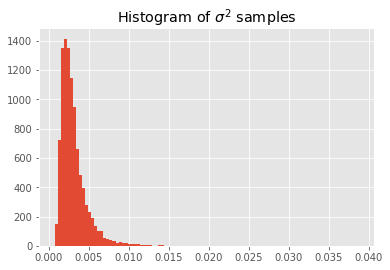

In [46]:
mh_sigmas = np.array(sigma_samples)
plt.hist(mh_sigmas**2,bins=100);
plt.title('Histogram of $\sigma^2$ samples')
plt.savefig('figures/T_2_2/Q2/plt_sigma.png')

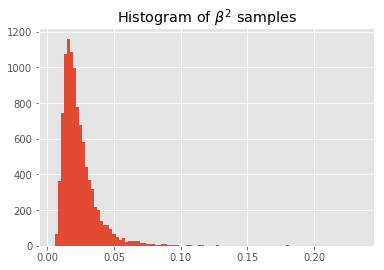

In [50]:
mh_beta = np.array(beta_samples)
plt.hist(mh_beta**2,bins=100);
plt.title('Histogram of $ \\beta^2$ samples')
plt.savefig('figures/T_2_2/Q2/plt_beta.png')

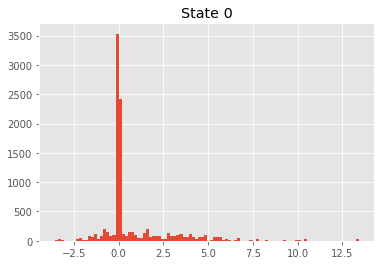

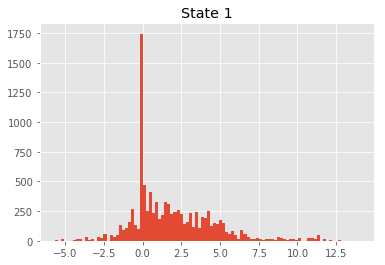

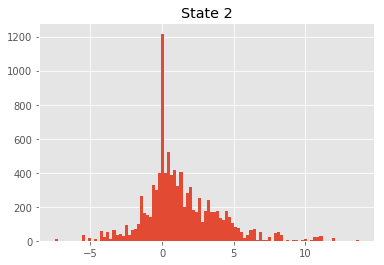

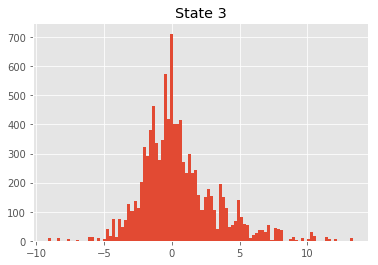

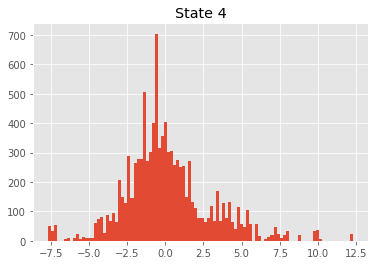

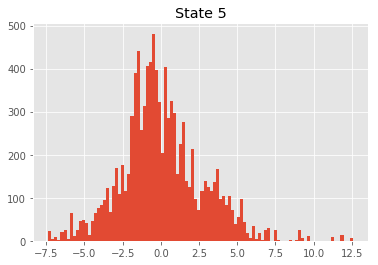

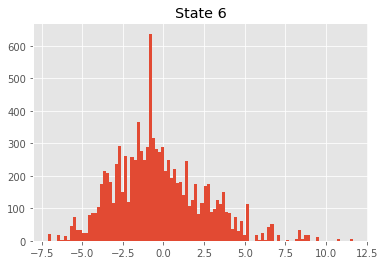

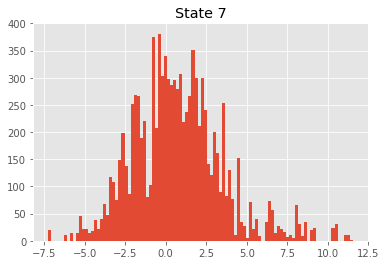

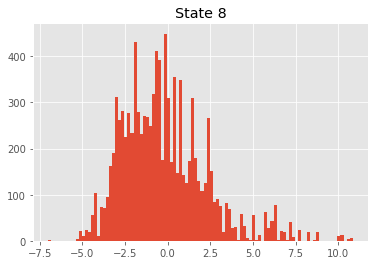

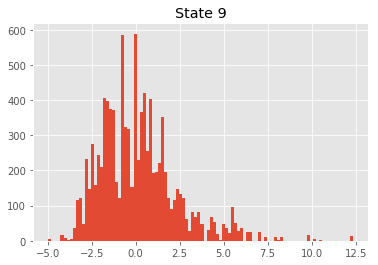

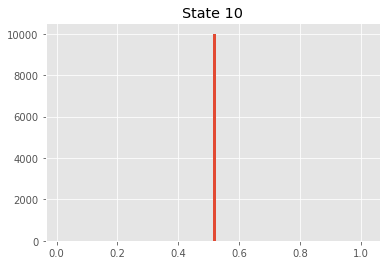

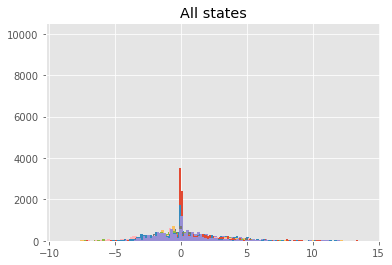

In [51]:
mh_data = np.array(x_samples)
x_dims = len(x0)
# separate
for i in range(x_dims):
    plt.hist(mh_data[:,i],bins=100)
    plt.title('State {}'.format(i))
    plt.savefig('figures/T_2_2/Q2/plt_x{}.png'.format(i))
    plt.show()

# together 
for i in range(x_dims):
    plt.hist(mh_data[:,i],bins=100)
plt.title('All states');
plt.savefig('figures/T_2_2/Q2/plt_x_all.png')
        

---

Additionaly, by using the template for Metropolis-Hastings, Gibbs sampler:

**NOTE:** Not part of the assignment!

In [ ]:
class GibbsSampler:
    
    def __init__(self,x0,T,N_bi):
        self.x=x0
        self.T=T
        self.sample(N_bi)
        
    def sample(self,N):
        x_current = self.x
        #prepare a samples list
        samples = []

        # for burn_in + N samples repeat
        for s in range(N):
            # for all variables udate every single one of them and add that as the new sample
            for t in range(self.T):
                x_t = g.rvs(t)
                x_current[t]=x_t
                g.update_state(x_current)                                
                samples.append(np.copy(x_current) )
                
        # update the last state to the new state
        self.x = x_current
        return samples

In [ ]:
class GibbsSampler:
    
    def __init__(self,x0,T,N_bi):
        self.x=x0
        self.T=T
        self.sample(N_bi)
        
    def sample(self,N):
        x_current = self.x
        #prepare a samples list
        samples = []

        # for burn_in + N samples repeat
        for s in range(N):
            # for all variables udate every single one of them and add that as the new sample
            for t in range(self.T):
                x_t = g.rvs(t)                

                x_next = np.copy(x_current)
                x_next[t] = x_t

                p_c = p.pdf(x_current)
                p_n = p.pdf(x_next)
                alpha = p_n/p_c
                r=min(1,alpha)

                # include sample
                u = st.uniform.rvs()
                if u < r:
                    x_current = x_next
                    g.update_state(x_current)
                    break
                    
            samples.append(x_current )
        # update the last state to the new state
        self.x = x_current
        return samples

In [ ]:
x0_g=np.array([ 0, 10, 20, 30, 40, 50 ])

In [ ]:
g_sampler = GibbsSampler(x0_g,T,N_bi=10000)

In [ ]:
g_samples=g_sampler.sample(N=10000)
g_data = np.array(g_samples)
x_dims = len(x0)
# separate
for i in range(x_dims):
    plt.plot(g_data[:,i])
    plt.title('State {}'.format(i))
    plt.show()
# together 
for i in range(x_dims):
    plt.plot(g_data[:,i])
plt.title('All states');    plt.savefig('figures/T_2_2/Q1/plt_x{}.png'.format(i))

        

In [ ]:
mh_mean=np.mean(mh_data,axis=0)
g_mean=np.mean(g_data,axis=0)

mh_std=np.std(mh_data,axis=0)
g_std=np.std(g_data,axis=0)

x_dims = len(x0)
# separate
x=np.linspace(-5,5,1000)
for i in range(x_dims):
    plt.plot(x,st.norm.pdf(x,loc=mh_mean[i],scale=mh_std[i]))
    plt.plot(x,st.norm.pdf(x,loc=g_mean[i],scale=g_std[i]))
    